In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import zipfile

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

import splitfolders
from tensorflow.keras.applications.resnet import ResNet50
import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [ ]:
with zipfile.ZipFile(base_path + 'Entropion.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
splitfolders.ratio('/content/Entropion', output = 'Entropion_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 13759 files [00:03, 3963.70 files/s]


## Zero-Centering

In [ ]:
train_path = '/content/Entropion_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [ ]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [ ]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

In [ ]:
batch_size = 128

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/Entropion_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/Entropion_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/Entropion_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 11007 images belonging to 2 classes.
Found 1375 images belonging to 2 classes.
Found 1377 images belonging to 2 classes.


In [ ]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50_zero = tf.keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
s_model_res50_zero.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [ ]:
# tensorboard log 저장
model_name = 'Entropion_ZeroCentering'
current_time = datetime.datetime.now().strftime("%m%d%H%M") # Y : 연도 / m : 월 / d : 일 / H : 시 / M : 분 / S : 초
current_time

'03270258'

In [ ]:
log_dir = "/content/drive/MyDrive/image_recognition/ayun/logs/ZeroCentering/" + current_time + model_name
board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # epoch마다 히스토그램 계산
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True) # EarlyStooping , restore_best_weights = True 가장 성능이 좋았을때 

history = s_model_res50.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks=[board, early]) # 콜백 전달

Epoch 1/10
86/86 [==============================] - 68s 588ms/step - loss: 1.2379 - accuracy: 0.9263 - recall: 0.9150 - val_loss: 0.0321 - val_accuracy: 0.9891 - val_recall: 0.9855
Epoch 2/10
86/86 [==============================] - 42s 479ms/step - loss: 0.0586 - accuracy: 0.9857 - recall: 0.9802 - val_loss: 0.0692 - val_accuracy: 0.9876 - val_recall: 0.9753
Epoch 3/10
86/86 [==============================] - 48s 556ms/step - loss: 0.0273 - accuracy: 0.9917 - recall: 0.9887 - val_loss: 0.0180 - val_accuracy: 0.9942 - val_recall: 0.9971
Epoch 4/10
86/86 [==============================] - 43s 497ms/step - loss: 0.0150 - accuracy: 0.9961 - recall: 0.9949 - val_loss: 0.0159 - val_accuracy: 0.9964 - val_recall: 0.9927
Epoch 5/10
86/86 [==============================] - 48s 557ms/step - loss: 0.0104 - accuracy: 0.9966 - recall: 0.9964 - val_loss: 0.0132 - val_accuracy: 0.9956 - val_recall: 0.9985
Epoch 6/10
86/86 [==============================] - 43s 500ms/step - loss: 0.0097 - accuracy: 0

In [ ]:
s_model_res50_zero.evaluate(test_generator)

11/11 [==============================] - 7s 587ms/step - loss: 0.0042 - accuracy: 0.9971 - recall: 0.9956


[0.004216927103698254, 0.9970951080322266, 0.9956395626068115]

In [ ]:
# 모델 저장 경로 및 파일명 지정
model_path = '/content/drive/MyDrive/image_recognition/js/model/Entropion_zero.h5'

# 모델 저장
s_model_res50_zero.save(model_path)

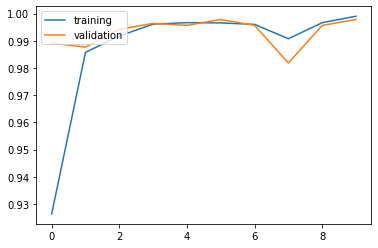

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

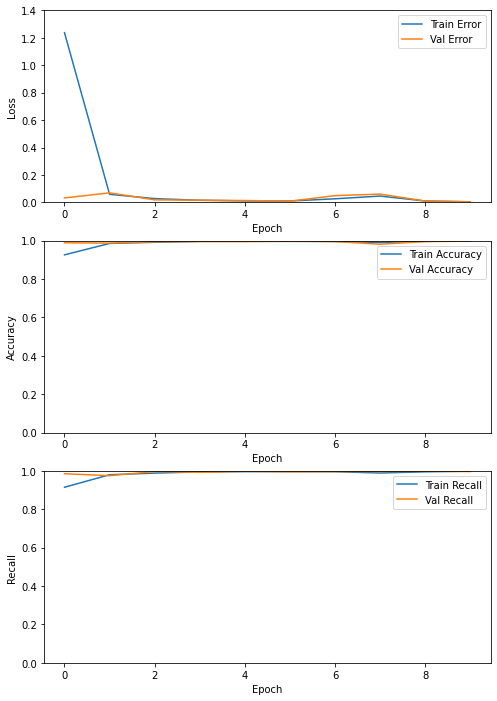

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## ImageDataGenerator 수정


In [ ]:
# width_shift_range=0.1,
# height_shift_range=0.1,

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 이미지 데이터 제너레이터 생성
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    preprocessing_function=sub_mean_img

)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=sub_mean_img)


In [ ]:
train_generator = train_datagen.flow_from_directory('/content/Entropion_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/Entropion_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/Entropion_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 11007 images belonging to 2 classes.
Found 1375 images belonging to 2 classes.
Found 1377 images belonging to 2 classes.


In [ ]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50 = tf.keras.Model(inputs, outputs)


In [ ]:
s_model_res50.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [ ]:
# tensorboard log 저장
model_name = 'Entropion_ImageDataGenerator'
current_time = datetime.datetime.now().strftime("%m%d%H%M") 

In [ ]:
log_dir = "/content/drive/MyDrive/image_recognition/ayun/logs/ImageDataGenerator/" + current_time + model_name
board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # epoch마다 히스토그램 계산
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True) # EarlyStooping , restore_best_weights = True 가장 성능이 좋았을때 

history = s_model_res50.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks=[board, early]) # 콜백 전달

Epoch 1/10
86/86 [==============================] - 135s 2s/step - loss: 1.0758 - accuracy: 0.5045 - recall: 0.5509 - val_loss: 0.6888 - val_accuracy: 0.6815 - val_recall: 0.3837
Epoch 2/10
86/86 [==============================] - 124s 1s/step - loss: 0.6964 - accuracy: 0.5193 - recall: 0.5362 - val_loss: 0.6824 - val_accuracy: 0.5302 - val_recall: 0.0610
Epoch 3/10
86/86 [==============================] - 129s 1s/step - loss: 0.6929 - accuracy: 0.5120 - recall: 0.4075 - val_loss: 0.6895 - val_accuracy: 0.6989 - val_recall: 0.4186
Epoch 4/10
86/86 [==============================] - 126s 1s/step - loss: 0.5600 - accuracy: 0.6857 - recall: 0.6265 - val_loss: 0.3158 - val_accuracy: 0.8807 - val_recall: 0.8009
Epoch 5/10
86/86 [==============================] - 130s 2s/step - loss: 0.2878 - accuracy: 0.8928 - recall: 0.8508 - val_loss: 0.2315 - val_accuracy: 0.9040 - val_recall: 0.8459
Epoch 6/10
86/86 [==============================] - 125s 1s/step - loss: 0.2487 - accuracy: 0.9032 - reca

In [ ]:
s_model_res50.evaluate(test_generator)

11/11 [==============================] - 5s 403ms/step - loss: 0.1780 - accuracy: 0.9136 - recall: 0.8299


[0.17804259061813354, 0.9135802388191223, 0.8299418687820435]

In [ ]:
# 모델 저장 경로 및 파일명 지정
model_path = '/content/drive/MyDrive/image_recognition/js/model/Entropion_ImageDataGenerator.h5'

# 모델 저장
s_model_res50.save(model_path)

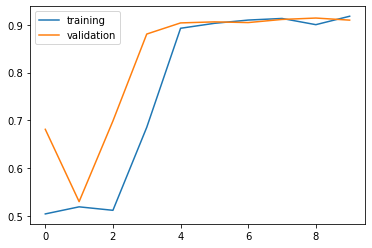

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

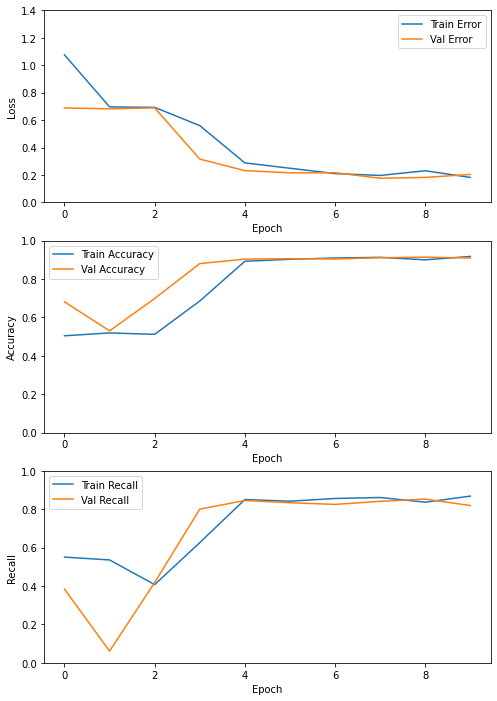

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)